# Introduction

This is the main analysis notebook that will fetch the data from the SQL db on Heroku, analyze it, visualize it and attempt to model it (work in progress).

# 1. Connect and inspect database

In [1]:
%matplotlib inline
import sys
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn; seaborn.set() # For pretty plots
# %config InlineBackend.figure_format='svg' # High res plots

### 1.1 Connect to the DB

We'll use the `psycopg2` package to connect to the PostreSQL DB on Heroku:

In [143]:
dbname = 'redacted'
host = 'redacted'
port = 'redacted'
user = 'redacted'
password = 'redacted'

In [3]:
import psycopg2
conn = psycopg2.connect(
   database = dbname,
   user = user,
   password = password,
   host = host,
   port = port
)

### 1.2 List all relevant tables and columns

Get all the relevant table names

In [7]:
sql_query = """
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_name LIKE 'main_%'
            """
table_list = pd.read_sql(sql_query, conn)

Get all the relevant column names

In [8]:
sql_query = """
            SELECT column_name, table_name 
            FROM information_schema.columns
            WHERE table_name LIKE 'main_%'
            """
col_list = pd.read_sql(sql_query, conn)

Massage them into a nice DF

In [9]:
# Generate a dictionary containing all column names
DF_dict = {}
for name in list(table_list['table_name']):
    DF_dict[name] = list(col_list[col_list['table_name'] == name]['column_name'])

# Fill it up so all lists are equal length
max_length = max([len(f) for f in DF_dict.values()])
for key, value in DF_dict.items():
    DF_dict[key] = DF_dict[key] + ['-----'] * (max_length - len(DF_dict[key]))

# Create a DataFrame
all_columns = pd.DataFrame(DF_dict)
all_columns

,main_comment,main_instagrammedia,main_survey,main_tags,main_user,main_usersinphoto
0,id,id,id,id,id,id
1,created_time,type,age,tag,username,username
2,text,mediaId,gender,photo_id,full_name,full_name
3,user_id,userId,race,-----,profilePictureUrl,profilePictureUrl
4,comment_id,likes,height,-----,userId,userId
5,photo_id,comments,weight,-----,profileImage,profileImage
6,-----,captionText,drinks,-----,bio,photo_id
7,-----,imageURL,tobacco,-----,website,-----
8,-----,image,prescription_drugs,-----,media,-----
9,-----,importDate,illegal_drugs,-----,follows,-----


### 1.3 Get general user data

Note `LEFT JOIN`, since some user may not have any media data, and also we're (temporarily) including `survey_id` column to weed out multiple entries:

In [40]:
sql_query = """
            SELECT distinct main_user."userId", age, gender, race, height, weight, drinks, 
                   tobacco, illegal_drugs, prescription_drugs, media, likes, comments, follows, followed_by 
            FROM main_user
            JOIN main_survey 
            ON main_user.survey_id = main_survey.id 
            LEFT JOIN (
                       SELECT SUM(likes) AS likes, sum(comments) AS comments, survey_id AS id 
                       FROM main_instagrammedia 
                       GROUP BY survey_id
                      ) media_totals 
            ON main_survey.id = media_totals.id;
            """
arradata = pd.read_sql(sql_query, conn)
len(arradata)

115

In [41]:
arradata.ix[:,1:].head() # Omitting 1st column since it contains user IDs

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,likes,comments,follows,followed_by
0,31,Male,White,170,51,Once or Twice,Daily or Almost Daily,Never,Daily or Almost Daily,0,NaN,NaN,0,0
1,30,Female,White,163,61,Once or Twice,Never,Never,Never,50,612.0,46.0,264,179
2,36,Female,White,163,68,Never,Never,Never,Never,0,NaN,NaN,0,0
3,31,Male,White,188,147,Never,Never,Never,Daily or Almost Daily,30,182.0,45.0,92,46
4,30,Female,White,165,72,Weekly,Once or Twice,Never,Never,647,4390.0,368.0,233,196


# 2. Clean up data, generate features and exploratory analysis

### 2.1 Clean up data

Quantify survey answers:

In [42]:
quantify_substances = {'Never': 1, 'Once or Twice': 2, 'Monthly': 3, 'Weekly': 4, 'Daily or Almost Daily': 5}

In [43]:
arradata['drinks'] = arradata['drinks'].replace(quantify_substances)
arradata['tobacco'] = arradata['tobacco'].replace(quantify_substances)
arradata['illegal_drugs'] = arradata['illegal_drugs'].replace(quantify_substances)
arradata['prescription_drugs'] = arradata['prescription_drugs'].replace(quantify_substances)

Replace the `NaN`'s in comments and likes (due to left join) with 0's:

In [44]:
arradata = arradata.fillna({'comments': 0, 'likes': 0})

Convert likes and comments to integers:

In [45]:
arradata['likes'] = arradata['likes'].astype(int)
arradata['comments'] = arradata['comments'].astype(int)

In [46]:
arradata.ix[:,1:].head()

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,likes,comments,follows,followed_by
0,31,Male,White,170,51,2,5,1,5,0,0,0,0,0
1,30,Female,White,163,61,2,1,1,1,50,612,46,264,179
2,36,Female,White,163,68,1,1,1,1,0,0,0,0,0
3,31,Male,White,188,147,1,1,1,5,30,182,45,92,46
4,30,Female,White,165,72,4,2,1,1,647,4390,368,233,196


Check there are no more missing data:

In [47]:
arradata.isnull().values.any()

False

Also remove duplicate users

In [48]:
arradata = arradata.drop_duplicates('userId')

Also remove ridiculous entries

In [49]:
arradata = arradata[arradata['age'] < 100]
arradata = arradata[arradata['age'] > 17]

Set the user id as the index, since it will be easier to merge with SNA later:

In [50]:
arradata.index = list(arradata['userId'])
arradata = arradata.drop('userId', axis = 1)

Finally, this is how many healthy records we have:

In [51]:
no_raw_features = arradata.shape[1]
arradata.shape

(110, 14)

### 2.2 Generate features

Generate some potentially interesting features:

In [53]:
arradata['mean_likes'] = arradata['likes'] / (arradata['media'] + 1)
arradata['mean_comments'] = arradata['comments'] / (arradata['media'] + 1)
arradata['follow_ratio'] = arradata['followed_by'] / (arradata['follows'] + 1)
arradata['magnetism'] = arradata['mean_likes'] * arradata['mean_comments'] * arradata['follow_ratio']
arradata['bmi'] = arradata['weight'] / ((arradata['height'] / 100) **2)

In [54]:
arradata['log_follow_ratio'] = np.log(arradata['follow_ratio'] + 1)
arradata['log_mean_activity'] = np.log(arradata['mean_likes'] * arradata['mean_comments'] + 1)
arradata['log_magnetism'] = np.log(arradata['magnetism'] + 1)

In [55]:
# Potentially for later:
# arradata['poster'] = no posts = yes
# arradata['lurker'] = no posts and follows lots of people = yes

Assign a BMI category:

In [56]:
def bmi_cat(bmi):
    if bmi < 18.5: bmi_score = 'Underweight'
    elif bmi < 25.0: bmi_score = 'Normal'
    elif bmi < 30.0: bmi_score = 'Overweight'
    else: bmi_score = 'Obese'
    return bmi_score

In [57]:
arradata['bmi_cat'] = arradata[['bmi']].applymap(bmi_cat)['bmi']

Ben's health score

In [58]:
bmi_score = {'Underweight': 2, 'Normal': 1, 'Overweight': 3, 'Obese': 4}
bmi_score_f = lambda t: bmi_score[t]

In [59]:
arradata['health_score'] = (arradata['drinks'] + arradata['tobacco'] + arradata['prescription_drugs'] + 
                            arradata['illegal_drugs'] + arradata[['bmi_cat']].applymap(bmi_score_f)['bmi_cat'])

We finally have:

In [60]:
arradata.reset_index().ix[:,1:].head() # Not showing index which now contains user IDs

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,...,mean_likes,mean_comments,follow_ratio,magnetism,bmi,log_follow_ratio,log_mean_activity,log_magnetism,bmi_cat,health_score
0,31,Male,White,170,51,2,5,1,5,0,...,0.000000,0.000000,0.000000,0.000000,17.647059,0.000000,0.000000,0.000000,Underweight,15
1,30,Female,White,163,61,2,1,1,1,50,...,12.000000,0.901961,0.675472,7.310988,22.959088,0.516095,2.470092,2.117578,Normal,6
2,36,Female,White,163,68,1,1,1,1,0,...,0.000000,0.000000,0.000000,0.000000,25.593737,0.000000,0.000000,0.000000,Overweight,7
3,31,Male,White,188,147,1,1,1,5,30,...,5.870968,1.451613,0.494624,4.215367,41.591218,0.401874,2.253644,1.651609,Obese,12
4,30,Female,White,165,72,4,2,1,1,647,...,6.774691,0.567901,0.837607,3.222571,26.446281,0.608464,1.578433,1.440444,Overweight,11


### 2.3 Basic exploratory analysis

Basic tabular summary:

In [61]:
interesting_rows = ['mean','std','min','max']
raw_features = list(arradata.describe().columns)[:(no_raw_features - 2)]
derivative_features = list(arradata.describe().columns)[(no_raw_features - 2):]

In [62]:
arradata.describe().loc[interesting_rows, raw_features] # Original features

,age,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,likes,comments,follows,followed_by
mean,32.227273,172.527273,82.509091,2.181818,2.090909,1.554545,1.290909,142.036364,4025.554545,273.290909,263.690909,307.190909
std,7.863117,9.545362,24.341887,1.150842,1.565367,1.018961,0.746189,237.244191,14070.956796,848.721244,461.503143,877.953558
min,19.000000,152.000000,36.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61.000000,193.000000,157.000000,5.000000,5.000000,5.000000,5.000000,1041.000000,114460.000000,6442.000000,3234.000000,5638.000000


In [63]:
arradata.describe().loc[interesting_rows, derivative_features] # Generated features

,mean_likes,mean_comments,follow_ratio,magnetism,bmi,log_follow_ratio,log_mean_activity,log_magnetism,health_score
mean,12.310917,0.833656,1.985858,164.431605,27.574879,0.614305,1.542687,1.509636,9.572727
std,24.277361,1.615982,7.527661,1001.447341,7.537530,0.657769,1.691414,1.934910,3.143244
min,0.000000,0.000000,0.000000,0.000000,15.581717,0.000000,0.000000,0.000000,5.000000
max,184.772834,12.620588,63.818182,9474.968625,57.667585,4.171586,7.362442,9.156514,18.000000


In [65]:
arradata.shape

(110, 24)

Boxplot of survey responses:

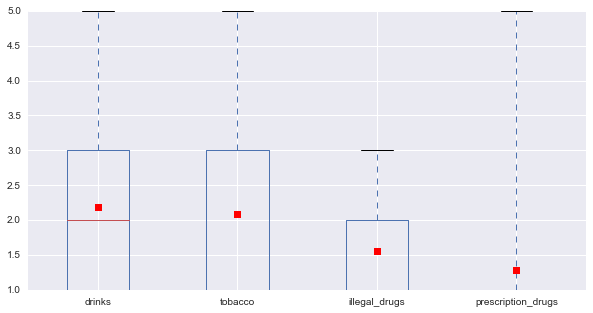

In [67]:
fig, ax = plt.subplots(figsize = (10, 5))
arradata[['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs']].plot.box(showmeans = True, ax = ax);

More detailed look into survey responses:

In [68]:
nRec = arradata.shape[0]
subst_count = pd.DataFrame(arradata['drinks'].value_counts()/ nRec)
subst_count['tobacco'] = arradata['tobacco'].value_counts()/ nRec
subst_count['illegal_drugs'] = arradata['illegal_drugs'].value_counts()/ nRec
subst_count['prescription_drugs'] = arradata['prescription_drugs'].value_counts()/ nRec

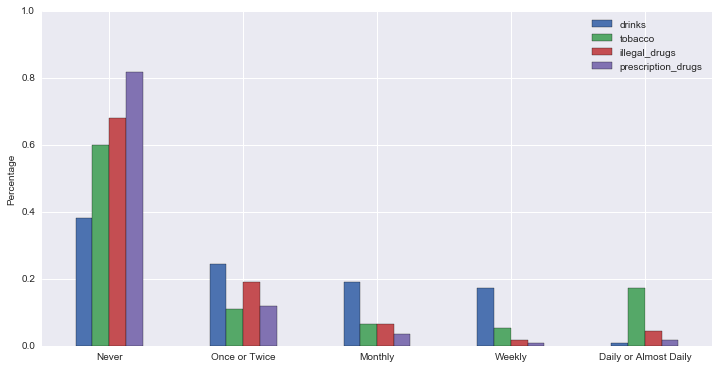

In [71]:
fig, ax = plt.subplots(figsize = (12, 6))
subst_count.plot.bar(ax = ax)
ax.set_xticklabels(['Never', 'Once or Twice', 'Monthly', 'Weekly', 'Daily or Almost Daily'],
                   rotation = 0, fontsize = 'small')
ax.set_ylim([0,1])
ax.set_ylabel('Percentage', fontsize = 'small');

I want nice, `ggplot`-looking plots, in which I plot one column vs. another, color by third (one could use `ggplot` for Python, but I wanna practice matplotlib):

In [74]:
def my_plot(df, x, y, label, width = 10, height = 6, marker = 'o', 
            ms = 7, fontsize = 12, linestyle = '', xlim = (0,0), ylim = (0,0), **args):
    groups = df.groupby(label)
    fig, ax = plt.subplots(figsize = (width, height))
    for name, group in groups:
        ax.plot(group[x], group[y], marker = marker, linestyle = linestyle, 
                ms = ms, label = name, **args)
    ax.set_xlabel(x, fontsize = fontsize)
    ax.set_ylabel(y, fontsize = fontsize)
    legend = ax.legend(frameon = False, bbox_to_anchor = (1.01, 0.99), loc=2, borderaxespad=0.)
    for label in legend.get_texts():
        label.set_fontsize(fontsize)
    if xlim != (0,0): ax.set_xlim([xlim[0], xlim[1]])
    if ylim != (0,0): ax.set_ylim([ylim[0], ylim[1]])
    plt.close()
    return fig

For example, let's see if there's any correlation between `follow_ratio` and `mean_activity`:

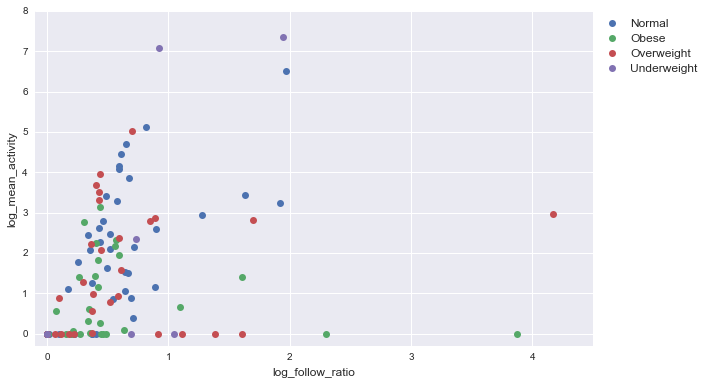

In [75]:
my_plot(arradata, x = 'log_follow_ratio', y = 'log_mean_activity', label = 'bmi_cat',
        xlim = (-0.1, 4.5), ylim = (-0.3, 8))

How predictive is magnetism (alone) of the health score?

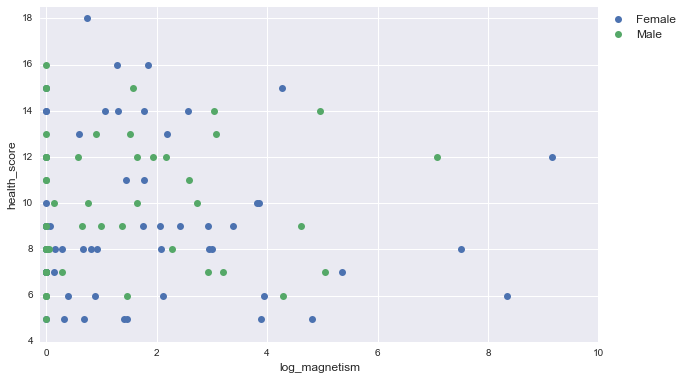

In [76]:
my_plot(arradata, x = 'log_magnetism', y = 'health_score', label = 'gender', 
        xlim = (-0.1, 10), ylim = (4, 18.5))

## 3. Get tag networks and related SNA metrics

### 3.1 Create a tag list

Concentrate on one particular user (later this can be embedded in a loop)

In [77]:
select_user_id = <redacted>

Find its username:

In [90]:
sql_query = (""" SELECT username FROM main_user 
            WHERE "userId" = '%s';""" % select_user_id)
username = pd.read_sql(sql_query, conn)['username'][0]
#username

Extract the list of all the ppl tagged in its photos:

In [91]:
sql_query = ("""
            SELECT username, photo_id, main_usersinphoto."userId"
            FROM main_usersinphoto
            JOIN main_instagrammedia ON main_usersinphoto.photo_id = main_instagrammedia.id
            WHERE main_instagrammedia."userId" = '%s';""" % select_user_id)
tag_data = pd.read_sql(sql_query, conn)
#tag_data.head()

Remove the user (for now) from the tag data:

In [92]:
tag_data = tag_data[tag_data['username'] != username]

Extract the list of all the people in its network:

In [81]:
taggers = list(tag_data['username'].unique())
nNodes = len(taggers) + 1

### 3.2 Generate the corresponding graph

Based on this, we initialize nNodes x nNodes weight matrix:

In [93]:
tag_matrix = np.array([0] * nNodes * nNodes).reshape((nNodes, nNodes))

For each of the users, add its position in the weight matrix to the tag_data DF:

In [94]:
tag_index = lambda user: taggers.index(user) + 1
tag_data['tag_index'] = tag_data[['username']].applymap(tag_index)['username']
# tag_data.head()

List of all the distinct photos:

In [95]:
photo_list = list(tag_data['photo_id'].unique())

For each photo, list of all the ppl (by tag_index) that are in it (adding a zero, for the central node):

In [96]:
tag_master = [[0] + list(tag_data[tag_data['photo_id'] == p]['tag_index']) for p in photo_list]
tag_master[0: min(5, len(tag_master) / 2)]

[[0, 1, 2, 3], [0, 2], [0, 4], [0, 5, 6, 2, 7, 8], [0, 9, 10]]

Convert this info into the weight matrix:

In [97]:
for t in tag_master:
    for i in range(len(t)):
        for j in range(i + 1, len(t)):
            tag_matrix[t[i], t[j]] = tag_matrix[t[i], t[j]] + 1

Use it to make a networkX graph:

In [98]:
G = nx.from_numpy_matrix(np.matrix(tag_matrix, dtype = [('weight', int)]))

Plot

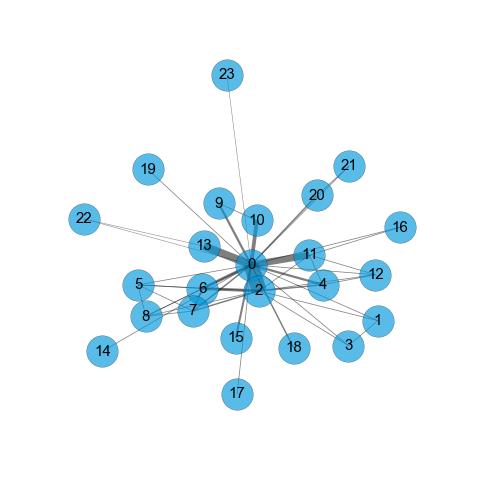

In [89]:
fac = 15. / float(np.amax(tag_matrix)) # So the edge widths are nicely scaled
edgeWidth = [fac * d['weight'] for (u, v, d) in G.edges(data = True)]
plt.rc('figure', figsize=(8, 8))
plt.axis('off')
#plt.title('Test - Network for Instagram User: ' + username, fontdict = {"fontsize": 20})
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1000, alpha = 0.65, node_color = '#0097db')
nx.draw_networkx_labels(G, pos, font_size = 15, font_family = 'sans-serif')
nx.draw_networkx_edges(G, pos, width = edgeWidth, alpha = 0.5);

### 3.3 Generate SNA metrics for all users

Here we employ methods from the previous sections to generate weight matrices in a loop for all users. Start with getting all the users:

In [102]:
sql_query = ("""
            SELECT main_instagrammedia."userId" user_id, photo_id, main_usersinphoto."userId" user_tagged
            FROM main_usersinphoto
            JOIN main_instagrammedia ON main_usersinphoto.photo_id = main_instagrammedia.id
            """)
all_tag_data = pd.read_sql(sql_query, conn)
#all_tag_data.head()

How many distinct users do we have:

In [103]:
users = list(all_tag_data['user_id'].unique())
len(users)

56

This can take a while so display a nice progress bar:

In [104]:
from ipywidgets import FloatProgress
from IPython.display import display
prog_bar = FloatProgress(min = 0, max = len(users))
display(prog_bar)

Loop over them and for each user generate a weighted tag network (note I need to introduce actual weights, i.e. the inverse of tag_matrix) and calculate some SNA metrics (working on adding more...)

In [105]:
import time
time_start = time.time()
largest_clique = pd.Series([])
density = pd.Series([])
edge_count = pd.Series([])
average_clustering = pd.Series([])
assortativity = pd.Series([])
clique_count = pd.Series([])
transitivity = pd.Series([])
connected = pd.Series([])
connected_components = pd.Series([])
biconnected = pd.Series([])
node_connectivity = pd.Series([])
edge_connectivity = pd.Series([])
average_connectivity = pd.Series([])
radius = pd.Series([])
diameter = pd.Series([])
average_shortest_path = pd.Series([])
isolates = pd.Series([])

for u in users:
    tag_data = all_tag_data[all_tag_data['user_id'] == u][['photo_id', 'user_tagged']]
    tag_data = tag_data[tag_data['user_tagged'] != u]
    taggers = list(tag_data['user_tagged'].unique())
    nNodes = len(taggers) + 1
    tag_matrix = np.array([0] * nNodes * nNodes).reshape((nNodes, nNodes))
    tag_index = lambda user: taggers.index(user) + 1
    tag_data['tag_index'] = tag_data[['user_tagged']].applymap(tag_index)['user_tagged']
    photo_list = list(tag_data['photo_id'].unique())
    tag_master = [[0] + list(tag_data[tag_data['photo_id'] == p]['tag_index']) for p in photo_list]
    for t in tag_master:
        for i in range(len(t)):
            for j in range(i + 1, len(t)):
                tag_matrix[t[i], t[j]] = tag_matrix[t[i], t[j]] + 1
    G = nx.from_numpy_matrix(np.matrix(tag_matrix, dtype = [('weight', int)]))
    
    largest_clique = largest_clique.append(pd.Series([nx.graph_clique_number(G)], index = [u]))
    density = density.append(pd.Series([nx.density(G)], index = [u]))
    edge_count = edge_count.append(pd.Series([nx.number_of_edges(G)], index = [u]))
    average_clustering = average_clustering.append(pd.Series([nx.average_clustering(G)], index = [u]))
    assortativity = assortativity.append(pd.Series([nx.degree_assortativity_coefficient(G)], index = [u]))
    clique_count = clique_count.append(pd.Series([nx.graph_number_of_cliques(G)], index = [u]))
    connected = connected.append(pd.Series([nx.is_connected(G)], index = [u]))
    connected_components = connected_components.append(pd.Series([nx.number_connected_components(G)], index = [u]))
    biconnected = biconnected.append(pd.Series([nx.is_biconnected(G)], index = [u]))
    node_connectivity = node_connectivity.append(pd.Series([nx.node_connectivity(G)], index = [u]))
    edge_connectivity = edge_connectivity.append(pd.Series([nx.edge_connectivity(G)], index = [u]))
    average_connectivity = average_connectivity.append(pd.Series([nx.average_node_connectivity(G)], index = [u]))
    radius = radius.append(pd.Series([nx.radius(G)], index = [u]))
    diameter = diameter.append(pd.Series([nx.diameter(G)], index = [u]))
    average_shortest_path = average_shortest_path.append(pd.Series([nx.average_shortest_path_length(G)], index = [u]))
    isolates = isolates.append(pd.Series([len(nx.isolates(G))], index = [u]))
    
    prog_bar.value += 1
time_end = time.time()
time_end - time_start

214.1476650238037

Add it to the main dataframe, and get rid of NA's;

In [116]:
arradata['largest_clique'] = largest_clique
arradata = arradata.fillna({'largest_clique': 0})
arradata['largest_clique'] = arradata['largest_clique'].astype(int)

arradata['density'] = density
arradata = arradata.fillna({'density': 0})
arradata['density'] = arradata['density'].astype(int)

arradata['edge_count'] = edge_count
arradata = arradata.fillna({'edge_count': 0})
arradata['edge_count'] = arradata['edge_count'].astype(int)

arradata['average_clustering'] = average_clustering
arradata = arradata.fillna({'average_clustering': 0})
arradata['average_clustering'] = arradata['average_clustering'].astype(int)

arradata['assortativity'] = assortativity
arradata = arradata.fillna({'assortativity': 0})
arradata['assortativity'] = arradata['assortativity'].astype(int)

arradata['clique_count'] = clique_count
arradata = arradata.fillna({'clique_count': 0})
arradata['clique_count'] = arradata['clique_count'].astype(int)

arradata['transitivity'] = transitivity
arradata = arradata.fillna({'transitivity': 0})
arradata['transitivity'] = arradata['transitivity'].astype(int)

arradata['connected'] = connected
arradata = arradata.fillna({'connected': 0})
arradata['connected'] = arradata['connected'].astype(int)

arradata['connected_components'] = connected_components
arradata = arradata.fillna({'connected_components': 0})
arradata['connected_components'] = arradata['connected_components'].astype(int)

arradata['biconnected'] = biconnected
arradata = arradata.fillna({'biconnected': 0})
arradata['biconnected'] = arradata['biconnected'].astype(int)

arradata['node_connectivity'] = node_connectivity
arradata = arradata.fillna({'node_connectivity': 0})
arradata['node_connectivity'] = arradata['node_connectivity'].astype(int)

arradata['edge_connectivity'] = edge_connectivity
arradata = arradata.fillna({'edge_connectivity': 0})
arradata['edge_connectivity'] = arradata['edge_connectivity'].astype(int)

arradata['average_connectivity'] = average_connectivity
arradata = arradata.fillna({'average_connectivity': 0})
arradata['average_connectivity'] = arradata['average_connectivity'].astype(int)

arradata['radius'] = radius
arradata = arradata.fillna({'radius': 0})
arradata['radius'] = arradata['radius'].astype(int)

arradata['diameter'] = diameter
arradata = arradata.fillna({'diameter': 0})
arradata['diameter'] = arradata['diameter'].astype(int)

arradata['average_shortest_path'] = average_shortest_path
arradata = arradata.fillna({'average_shortest_path': 0})
arradata['average_shortest_path'] = arradata['average_shortest_path'].astype(int)

arradata['isolates'] = isolates
arradata = arradata.fillna({'isolates': 0})
arradata['isolates'] = arradata['isolates'].astype(int)

arradata.reset_index().ix[:,1:].head()

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,...,connected,connected_components,biconnected,node_connectivity,edge_connectivity,average_connectivity,radius,diameter,average_shortest_path,isolates
0,31,Male,White,170,51,2,5,1,5,0,...,0,0,0,0,0,0,0,0,0,0
1,30,Female,White,163,61,2,1,1,1,50,...,1,1,1,1,1,1,1,1,1,0
2,36,Female,White,163,68,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,31,Male,White,188,147,1,1,1,5,30,...,1,1,0,1,1,1,1,2,1,0
4,30,Female,White,165,72,4,2,1,1,647,...,1,1,0,1,1,1,1,2,1,0


Check for zero variance SNA metrics and remove them:

In [107]:
sna_loc_start = list(arradata.columns).index('largest_clique')
sna_loc_end = arradata.shape[1]

In [108]:
trivial_cols_index = []
for i in range(sna_loc_start, sna_loc_end):
    if len(arradata.ix[:, i].unique()) == 1: trivial_cols_index.append(i)
trivial_cols = [list(arradata.columns)[index] for index in trivial_cols_index]
trivial_cols

['average_clustering', 'transitivity', 'isolates']

In [109]:
ad_cleaned = arradata.drop(trivial_cols, axis = 1)

Find perfectly correlated columns and remove them:

In [110]:
sna_corr = ad_cleaned.ix[:, sna_loc_start:].corr()

In [111]:
corrs = []
for i in range(sna_corr.shape[0]):
    ones = sna_corr.ix[i][sna_corr.ix[i] == 1.0].index.tolist()
    ones_ind = [sna_corr.columns.tolist().index(o) for o in ones]
    if (len(ones_ind) > 1) and ones_ind not in corrs: corrs.append(ones_ind)
corrs_labels = [[sna_corr.columns.tolist()[a] for a in c] for c in corrs]
corrs_labels

[['connected', 'connected_components', 'radius', 'average_shortest_path']]

In [112]:
for l in corrs_labels:
    ad_cleaned = ad_cleaned.drop(l[1:], axis = 1)

These are the nontrivial SNA metrics:

In [120]:
ad_cleaned.reset_index().ix[:, (sna_loc_start+1):].head()

,largest_clique,density,edge_count,assortativity,clique_count,connected,biconnected,node_connectivity,edge_connectivity,average_connectivity,diameter
0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0
3,2,0,2,-1,2,1,0,1,1,1,2
4,4,0,20,0,11,1,0,1,1,1,2


For later: need to implement the actual weight matrix for correct SNA:

In [114]:
weight_matrix = 1. / tag_matrix
np.place(weight_matrix, weight_matrix == np.inf, 0)

Close connection:

In [115]:
conn.close()

# 4. Classification

In [139]:
import sklearn.metrics
from sklearn.preprocessing import Binarizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

### 4.1 Feature subselection and preprocessing

Dichotomize responses for a first stab at classification:

In [123]:
arradata['dichot_tobacco'] = Binarizer(threshold = 1.5).transform(arradata['tobacco']).flatten()
arradata['dichot_drinks'] = Binarizer(threshold = 1.5).transform(arradata['drinks']).flatten()
arradata['dichot_illegal_drugs'] = Binarizer(threshold = 1.5).transform(arradata['illegal_drugs']).flatten()
arradata['dichot_prescription_drugs'] = Binarizer(threshold = 1.5).transform(arradata['prescription_drugs']).flatten()

/Volumes/Scratch/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Volumes/Scratch/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Volumes/Scratch/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

Remove some of the columns:

In [124]:
remove_columns = ['drinks','tobacco','illegal_drugs','prescription_drugs','magnetism','follow_ratio',
                  'bmi_cat','health_score']

In [125]:
XDesign_raw = ad_cleaned.drop(remove_columns, axis = 1)
print(XDesign_raw.columns.tolist())

['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'largest_clique', 'density', 'edge_count', 'assortativity', 'clique_count', 'connected', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'diameter']


In `sklearn`, all features need to be numerical -- check which are not:

In [126]:
nonnumber_cols = XDesign_raw.dtypes[(XDesign_raw.dtypes != 'int64') & (XDesign_raw.dtypes != 'float64')]
nonnumber_cols

gender    object
race      object
dtype: object

Replace those with dummies:

In [127]:
XDesign = pd.get_dummies(XDesign_raw)
num_dummies = XDesign.shape[1] - (XDesign_raw.shape[1] - 2)
XDesign.ix[:, -num_dummies:] = XDesign.ix[:, -num_dummies:].astype('int64')

In [129]:
XDesign.reset_index().ix[:, 1:].head()

,age,height,weight,media,likes,comments,follows,followed_by,mean_likes,mean_comments,...,edge_connectivity,average_connectivity,diameter,gender_Female,gender_Male,race_Asian,race_Black,race_Hispanic/Latino,race_Other,race_White
0,31,170,51,0,0,0,0,0,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,1
1,30,163,61,50,612,46,264,179,12.000000,0.901961,...,1,1,1,1,0,0,0,0,0,1
2,36,163,68,0,0,0,0,0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
3,31,188,147,30,182,45,92,46,5.870968,1.451613,...,1,1,2,0,1,0,0,0,0,1
4,30,165,72,647,4390,368,233,196,6.774691,0.567901,...,1,1,2,1,0,0,0,0,0,1


We also need to standardize the features:

In [133]:
X_scaled = preprocessing.scale(XDesign)

Finally, put each of the responses in a list:

In [137]:
YResponse = [np.array(arradata['dichot_drinks']), np.array(arradata['dichot_tobacco']),
            np.array(arradata['dichot_illegal_drugs']), np.array(arradata['dichot_prescription_drugs'])]
Y_labels = ['drinks','tobacco','illegal_drugs','prescription_drugs']

### 4.2 kNN

Since we don't have much data at this point, try kNN, with different number of neighbors and two different metrics:

In [140]:
knn_res_p1 = {}
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    cv_means = []
    for n in range(1,6):
        clf = KNeighborsClassifier(n_neighbors = n, p = 1)
        cv = cross_val_score(clf, X_train, y_train, cv = 10)
        cv_means.append(cv.mean())
    knn_res_p1[Y_labels[i]] = cv_means

In [141]:
knn_res_p2 = {}
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    cv_means = []
    for n in range(1,6):
        clf = KNeighborsClassifier(n_neighbors = n, p = 2)
        cv = cross_val_score(clf, X_train, y_train, cv = 10)
        cv_means.append(cv.mean())
    knn_res_p2[Y_labels[i]] = cv_means

In [142]:
pd.DataFrame(knn_res_p1, index = range(1,6))

,drinks,illegal_drugs,prescription_drugs,tobacco
1,0.524722,0.612698,0.6875,0.554444
2,0.496667,0.593651,0.8150,0.500000
3,0.573333,0.649206,0.7725,0.524722
4,0.540278,0.615873,0.8250,0.492778
5,0.649444,0.604762,0.8150,0.558333


In [143]:
pd.DataFrame(knn_res_p2, index = range(1,6))

,drinks,illegal_drugs,prescription_drugs,tobacco
1,0.593333,0.615873,0.6750,0.583056
2,0.571389,0.674603,0.8075,0.502500
3,0.590000,0.652381,0.7725,0.472778
4,0.577778,0.649206,0.8150,0.459167
5,0.606111,0.604762,0.7925,0.492500


For some of this, we need to look at F1 score (to come).

### 4.3 Random forest

Since kNN is not working that great, let's try the most popular ensemble classifier:

In [144]:
rf_res = []
clf = RandomForestClassifier(n_estimators = 500)
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rf_res.append(accuracy_score(y_test, y_pred))
rf_res

[0.54545454545454541,
 0.45454545454545453,
 0.72727272727272729,
 0.77272727272727271]

Next: play with `max_features` and `max_depth`...

### 4.4 SVM

Another good non-linear classifier is SVM, try it with a standard Gaussian kernel:

In [145]:
clf = SVC(kernel='rbf')
svm_res = []
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    cv = cross_val_score(clf, X_train, y_train, cv = 10)
    svm_res.append(cv.mean())
svm_res

[0.6380555555555556,
 0.45416666666666661,
 0.67142857142857149,
 0.84499999999999997]

Next: will play with `kernel`, `C`, and `gamma`